In [1]:
import pandas as pd
import numpy as np
import random
import math
import re
from scipy.special import psi #digamma function
from scipy.special import polygamma #derivative of digamma function
from scipy.special import loggamma
from IPython.display import display
import numpy.random
from nltk.tokenize import wordpunct_tokenize
import sys
import csv
import nltk
from nltk.corpus import stopwords #import stopwords
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import time
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1234)
meanchangethresh = 1e-3
MAXITER = 10000

In [3]:
def getVocab(file):
	#getting vocab dictionary from a csv file (nostopwords)'''
	vocab = dict()
	with open(file, 'r') as infile:
		reader = csv.reader(infile)
		for index, row in enumerate(reader):
			vocab[row[0]] = index

	return vocab

In [4]:
def getDocs(file_path):
    with open(file_path,encoding="utf-8") as f:
        docs=f.readlines()
        
    return(docs)

In [5]:
def dirichlet_expectation(a):
    if (len(a.shape)==1):
        return (psi(a)-psi(np.sum(a)))
    return (psi(a)-psi(np.sum(a,1))[:,np.newaxis])


In [6]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [7]:
def parseDocument(doc, vocab):
    #preprocessing document data
	wordslist = list()
	countslist = list()
	doc = doc.lower()
	tokens = nltk.word_tokenize(doc)#wordpunct_tokenize(doc)
	remove_chars = '[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    
	tokens=[re.sub(remove_chars,"",x.lower()) for x in tokens]
	tokens=[x for x in tokens if x!='']
    # 词形还原
	tagged_sent = pos_tag(tokens)
	wnl = WordNetLemmatizer()
	lemmas_sent = []
	for tag in tagged_sent:
		wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
		lemmas_sent.append(wnl.lemmatize(tag[0], pos=wordnet_pos)) 
	tokens=lemmas_sent

	dictionary = dict()
	for word in tokens:
		if word in vocab:
			wordtk = vocab[word]
			if wordtk not in dictionary:
				dictionary[wordtk] = 1
			else:
				dictionary[wordtk] += 1

	wordslist.append(dictionary.keys())
	countslist.append(dictionary.values())
	return (wordslist[0], countslist[0])

In [8]:
def plottrace(x, Y, K, n):
	for i in range(K):
		plt.plot(x, Y[i], label = "Topic %i" %(i+1))

	plt.xlabel("Number of Iterations")
	plt.ylabel("Probability of Each topic")
	plt.legend()
	plt.title("Trace plot for topic probabilities")
	plt.savefig("plot_%i_%i.png" %(K, n))

In [9]:
class SVILDA():
	def __init__(self, vocab, K, D, alpha, eta, tau, kappa, docs, iterations, parsed = False):
		self._vocab = vocab
		self._V = len(vocab)
		self._K = K
		self._D = D
		self._alpha = alpha
		self._eta = eta
		self._tau = tau
		self._kappa = kappa
		self._lambda = 1* np.random.gamma(100., 1./100., (self._K, self._V))
		self._Elogbeta = dirichlet_expectation(self._lambda)
		self._expElogbeta = np.exp(self._Elogbeta)
		self._docs = docs
		self.ct = 1 
		self._iterations = iterations
		self._parsed = parsed
		print (self._lambda.shape)
		#print (self._lambda)        
		self._trace_lambda = {} #record lambda in every 10th iteration
		for i in range(self._K):
			#print(self.computeProbabilities()[i])            
			self._trace_lambda[i] = [self.computeProbabilities()[i]]
		self._x = [0]
		self._ELBO = list()


	def updateLocal(self, doc): #word_dn is an indicator variable with dimension V?????
		print("Updating local parameters")
		(words, counts) = doc
		newdoc = []
		N_d = sum(counts) #total number of words in this doc
		phi_d = np.zeros((self._K, N_d))
		gamma_d = np.ones(self._K)#np.random.gamma(100., 1./100., (self._K))
		Elogtheta_d = dirichlet_expectation(gamma_d)
		expElogtheta_d = np.exp(Elogtheta_d)
		for i, item in enumerate(counts):
			for j in range(item):
				newdoc.append(list(words)[i])
		assert len(newdoc) == N_d, "error" #当len不等于N_d时，触发异常
        
		inner_iteration = 20
		inner_thresh = 0.1

		for i in range(inner_iteration):
			for m, word in enumerate(newdoc):
				phi_d[:, m] = np.multiply(expElogtheta_d, self._expElogbeta[:, word]) #+ 1e-100
				phi_d[:, m] = phi_d[:, m]/np.sum(phi_d[:, m]) #normalize

			gamma_new = self._alpha + np.sum(phi_d, axis = 1)
			meanchange = np.mean(abs(gamma_d - gamma_new))

			if (meanchange < inner_thresh):
				break

			gamma_d = gamma_new
			#print(gamma_d)
			Elogtheta_d = dirichlet_expectation(gamma_d)
			expElogtheta_d = np.exp(Elogtheta_d)

		newdoc = np.asarray(newdoc)

		return phi_d, newdoc, gamma_d

	def updateGlobal(self, phi_d, doc):
		print ('updating global parameters')
		lambda_d = np.zeros((self._K, self._V))

		for k in range(self._K):
			phi_dk = np.zeros(self._V)
			for m, word in enumerate(doc):
					# print word
				phi_dk[word] += phi_d[k][m] 
			lambda_d[k] = self._eta + self._D * phi_dk
		#print("this is lambda_d",lambda_d)
		rho = (self.ct + self._tau) **(-self._kappa)
		#print("this is lambda before updating",self._lambda)
		self._lambda = (1-rho) * self._lambda + rho * lambda_d
		#print(self._lambda)
		self._Elogbeta = dirichlet_expectation(self._lambda)
		self._expElogbeta = np.exp(self._Elogbeta)

#		if self.ct>-1:#% 10 == 9:
#			for i in range(self._K):
#				self._trace_lambda[i].append(self.computeProbabilities()[i])
#			self._x.append(self.ct)
            
	def runSVI(self):
		#random.seed(1234)

		for i in range(self._iterations):			
			randint = random.randint(0, self._D-1)
			print ("ITERATION", i, " running document number ", randint)
			if self._parsed == False:
				doc = parseDocument(self._docs[randint],self._vocab)
				phi_doc, newdoc, gamma_d = self.updateLocal(doc)
				self.updateGlobal(phi_doc, newdoc)
                
				if self.ct>-1:#% 10 == 9:
					for i in range(self._K):
						#print("This is trace lambda:",self.computeProbabilities()[i],self.ct)                        
						self._trace_lambda[i].append(self.computeProbabilities()[i])
					self._x.append(self.ct)
                    
				ELBO = self.Calculate_doc_L(newdoc,phi_doc,gamma_d)
				self._ELBO.append(ELBO)                
				self.ct += 1


	def computeProbabilities(self):

		prob_topics = np.sum(self._lambda, axis = 1)
		prob_topics = prob_topics/np.sum(prob_topics)
		return prob_topics

	def getTopics(self, docs = None):
		prob_topics = self.computeProbabilities()
		prob_words = np.sum(self._lambda, axis = 0)

		if docs == None:
			docs = self._docs
		results = np.zeros((len(docs), self._K))
		for i, doc in enumerate(docs):
			parseddoc = parseDocument(doc, self._vocab)

			for j in range(self._K):
				aux = [self._lambda[j][word]/prob_words[word] for word in parseddoc[0]]
				doc_probability = [np.log(aux[k]) * list(parseddoc[1])[k] for k in range(len(aux))]
				results[i][j] = sum(doc_probability) + np.log(prob_topics[j])
		finalresults = np.zeros(len(docs))
		for k in range(len(docs)):
			finalresults[k] = np.argmax(results[k])
		return finalresults, prob_topics

	def calcPerplexity(self, docs = None):
		perplexity = 0.
		doclen = 0.
		if docs == None:
			docs =  self._docs
		for doc in docs:
			parseddoc = parseDocument(doc, self._vocab)
			_, newdoc, gamma_d = self.updateLocal(parseddoc)
			approx_mixture = np.dot(gamma_d, self._lambda)
			# print n.shape(approx_mixture)
			approx_mixture = approx_mixture / np.sum(approx_mixture)
			log_doc_prob = 0.
			for word in newdoc:
				log_doc_prob += np.log(approx_mixture[word])
			perplexity += log_doc_prob
			doclen += len(newdoc)
			# print perplexity, doclen
		perplexity = np.exp( - perplexity / doclen)
		print (perplexity)
		return perplexity

	def plotTopics(self):
		plottrace(self._x, self._trace_lambda, self._K, self._iterations)
			

            
	def Calculate_doc_L(self,new_doc,phi_d,gamma_d):
		l=0
        
		l += loggamma(self._K*self._alpha) - self._K*loggamma(self._alpha) - loggamma(sum(gamma_d)) + sum(loggamma(gamma_d))
		l += sum((self._alpha-gamma_d) * dirichlet_expectation(gamma_d))
		for k in range(self._K):
			l += loggamma(self._V*self._eta) - self._V*loggamma(self._eta) - loggamma(sum(self._lambda[k]))+sum(loggamma(self._lambda[k]))
			l += sum((self._eta-self._lambda[k]) * dirichlet_expectation(self._lambda[k]))
		for n in range(len(new_doc)):
			l += sum(phi_d[:,n] * dirichlet_expectation(gamma_d))
			l += sum(phi_d[:,n] * np.log(phi_d[:,n]))
			for k in range(self._K):
				for j in range(self._V):
					if j == new_doc[n]:
						l += phi_d[k][n]*dirichlet_expectation(self._lambda[k])[j]
            
                
		return(l)

In [10]:
def Generate_Data(num_topic,voc_size,num_doc,xi,alpha,eta):
    num_word=np.repeat(xi,num_doc)#np.random.poisson(xi,num_doc) #number of words in each document
    
    beta=np.zeros([num_topic,voc_size])
    for i in range(num_topic):
        beta[i]=np.random.dirichlet(eta)
    
    theta=np.zeros([num_doc,num_topic])
    for d in range(num_doc):
        theta[d]=np.random.dirichlet(alpha)
    
    doc={}
    for d in range(num_doc):
        W=np.zeros([voc_size,num_word[d]])
        for n in range(num_word[d]):
            z=np.random.multinomial(1,theta[d])
            topic_index=np.where(z==1)[0][0]
            w=np.random.multinomial(1,beta[topic_index,])
            W[:,n]=w
        doc[d]=W
                            
    return doc,beta,theta




np.random.seed(12345)
K=2
V=8
D=1000
xi=100
true_alpha=[0.05 for i in range(K)]
true_eta=[1.0 for i in range(V)]
docs,true_beta,true_theta=Generate_Data(K,V,D,xi,true_alpha,true_eta)

vocab={'i': 0,
 'new': 1,
 'percent': 2,
 'people': 3,
 'year': 4,
 'two': 5,
 'million': 6,
 'president': 7}
key_list=list(vocab.keys())
value_list=list(vocab.values())

new_docs=list()
for d in range(D):
    new_doc = ""
    Nd = len(docs[d][0])
    for n in range(Nd):
        pos = np.where(docs[d][:,n]==1)[0][0]
        new_doc += " "+key_list[pos]
    new_docs.append(new_doc)
    




In [11]:
real_docs = getDocs("Abstract_data.txt")
real_vocab = getVocab("vocab.csv")
key_list=list(real_vocab.keys())
value_list=list(real_vocab.values())

In [12]:
random.seed(1235)
start=time.time()
k=2
alpha=0.1
iterations=100
d=len(new_docs)
test=SVILDA(vocab = vocab, K = k, D = d, alpha = alpha, eta = 0.2, tau = 0.7, kappa = 0.7, docs = new_docs, iterations= iterations)
test.runSVI()
end=time.time()
print ("Running time:",str(end-start),"seconds")

(2, 8)
ITERATION 0  running document number  930
Updating local parameters
updating global parameters
ITERATION 1  running document number  705
Updating local parameters
updating global parameters
ITERATION 2  running document number  434
Updating local parameters
updating global parameters
ITERATION 3  running document number  548
Updating local parameters
updating global parameters
ITERATION 4  running document number  862
Updating local parameters
updating global parameters
ITERATION 5  running document number  606
Updating local parameters
updating global parameters
ITERATION 6  running document number  481
Updating local parameters
updating global parameters
ITERATION 7  running document number  400
Updating local parameters
updating global parameters
ITERATION 8  running document number  152
Updating local parameters
updating global parameters
ITERATION 9  running document number  977
Updating local parameters
updating global parameters
ITERATION 10  running document number  724


ITERATION 88  running document number  466
Updating local parameters
updating global parameters
ITERATION 89  running document number  426
Updating local parameters
updating global parameters
ITERATION 90  running document number  305
Updating local parameters
updating global parameters
ITERATION 91  running document number  668
Updating local parameters
updating global parameters
ITERATION 92  running document number  19
Updating local parameters
updating global parameters
ITERATION 93  running document number  213
Updating local parameters
updating global parameters
ITERATION 94  running document number  89
Updating local parameters
updating global parameters
ITERATION 95  running document number  450
Updating local parameters
updating global parameters
ITERATION 96  running document number  785
Updating local parameters
updating global parameters
ITERATION 97  running document number  142
Updating local parameters
updating global parameters
ITERATION 98  running document number  885

In [13]:
beta=test._lambda
for i in range(k):
    beta[i]=beta[i]/np.sum(beta[i])
pd.DataFrame(np.around(beta,3))

,0,1,2,3,4,5,6,7
0,0.161,0.124,0.164,0.384,0.000,0.012,0.039,0.116
1,0.279,0.042,0.024,0.017,0.088,0.102,0.338,0.110


In [14]:
pd.DataFrame(np.around(true_beta,3))

,0,1,2,3,4,5,6,7
0,0.276,0.040,0.021,0.024,0.087,0.094,0.347,0.110
1,0.160,0.123,0.160,0.377,0.001,0.013,0.041,0.124


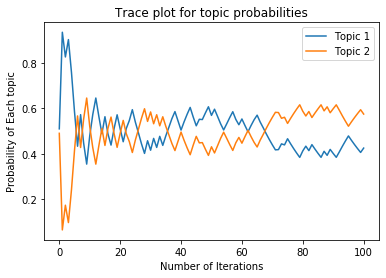

In [15]:
test.plotTopics()

In [16]:
#Calculate the top 5 words in each topic
topic_words=[]
max_num=10
for i in range(0,K):
    #topic_words.append([])
    sorted_beta_index=beta[i,:].argsort()
    topicword=[]
    for j in sorted_beta_index:
        topicword.insert(0,key_list[j])
    topic_words.append(topicword[0:min(max_num,len(topicword))])
topic_words

[['people', 'percent', 'i', 'new', 'president', 'million', 'two', 'year'],
 ['million', 'i', 'president', 'two', 'year', 'new', 'percent', 'people']]